Original target class distribution:
avg_D
3    176
0     96
2     37
1     27
Name: count, dtype: int64
Class distribution after SMOTE-Tomek:
avg_D
2    151
0    142
1    139
3    134
Name: count, dtype: int64
Sample of training data:
[[ 2.63132976e+00 -1.26060428e+00  1.31317260e+00  3.02640802e+00
   1.27466791e+00 -1.43399805e-01  1.26391195e+00  2.56158045e+00
  -1.22129890e+00  2.63132976e+00 -1.26060428e+00  1.31317260e+00
   3.02640802e+00  1.27466791e+00 -1.43399805e-01  1.26391195e+00
   2.56158045e+00 -1.22129890e+00  2.22676730e+00  2.69938595e+00
   2.70753338e+00  1.71136243e+00 -2.54850578e-02  2.00407203e+00
   2.22178221e+00  1.83171357e+00 -1.04476694e+00  2.63132968e+00
   1.12935353e+00 -1.43836897e-01  1.02732069e+00  2.16842979e+00
  -1.17502860e+00  3.10545443e+00  1.29574783e+00 -1.44687410e-01
   1.29405239e+00  2.63133832e+00 -1.13017394e+00  2.03137307e+00
  -3.85899124e-02  2.44865572e+00  2.63806435e+00  2.22676722e+00
   2.62485036e-02  9.04647748e-01  1.68

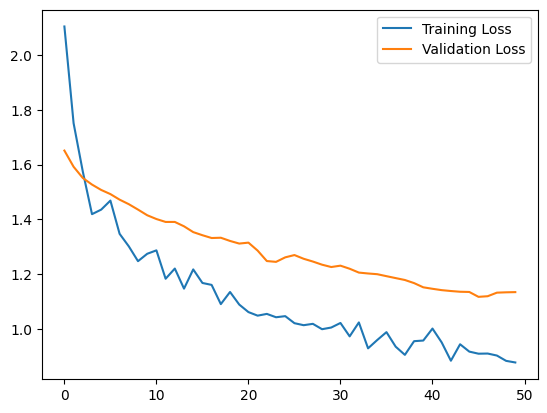

Neural Network Evaluation:
Loss: 1.1380329132080078, Accuracy: 0.7368420958518982


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:51:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        24
           1       0.95      0.87      0.91        23
           2       0.87      0.90      0.88        29
           3       0.87      0.68      0.76        38

    accuracy                           0.83       114
   macro avg       0.85      0.85      0.84       114
weighted avg       0.85      0.83      0.83       114

Enter precipitation value: 90
Enter temperature value: 75
Enter soil moisture value: 0.8
Scaled Input Features for User Input:
[[ 3.71610853e+01  4.28143432e+00  4.49404559e+02  2.47203586e+01
   2.29038631e-02 -1.43399805e-01 -5.30412473e-01  3.24472928e+00
   5.15876575e+00  3.71610853e+01  4.28143432e+00  4.49404559e+02
   2.47203586e+01  2.29038631e-02 -1.43399805e-01 -5.30412473e-01
   3.24472928e+00  5.15876575e+00  5.45555782e+01  3.73527792e+02
   2.55800710e+02 -2.27163051e-01 -2.54850578e-02 -2.77839896e-01
   3.671131

In [26]:
# final implementation
# import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# define functions to load each dataset
def load_precipitation_data():
    precipitation_data = pd.read_csv("MonthlyPrecipitationLASCSFSAC.csv")
    precipitation_data.rename(columns={'PrecipitationColumn': 'VALUE'}, inplace=True)
    return precipitation_data

def load_temperature_data():
    temperature_data = pd.read_csv("temperature.csv")
    temperature_data.rename(columns={'TemperatureColumn': 'Avg_Air_Temp_(F)'}, inplace=True)
    return temperature_data

def load_soil_moisture_data():
    soil_moisture_files = [
        "Schmidt_2020_CANVQSM1.csv",
        "Schmidt_2020_CANVQSM2.csv",
        "Schmidt_2020_CANVQSM3.csv"
    ]
    soil_moisture_data = pd.concat([pd.read_csv(file) for file in soil_moisture_files], ignore_index=True)
    soil_moisture_data.rename(columns={'SoilMoistureColumn': 'CANVQSM1_1187212_15'}, inplace=True)
    return soil_moisture_data

def load_drought_labels():
    drought_labels = pd.read_csv("percent_area.csv")
    return drought_labels['avg_D']
# preprocessing and Training Function
def preprocess_and_train_ensemble():
    # loading datasets
    X_precipitation = load_precipitation_data()['VALUE']
    X_temperature = load_temperature_data()['Avg_Air_Temp_(F)']
    X_soil_moisture = load_soil_moisture_data()['CANVQSM1_1187212_15']
    y = load_drought_labels()

    # aligning datasets
    min_length = min(len(X_precipitation), len(X_temperature), len(X_soil_moisture), len(y))
    X_precipitation = X_precipitation.iloc[:min_length]
    X_temperature = X_temperature.iloc[:min_length]
    X_soil_moisture = X_soil_moisture.iloc[:min_length]
    y = y.iloc[:min_length]

    # converting to numeric
    X_precipitation = pd.to_numeric(X_precipitation, errors='coerce').fillna(0)
    X_temperature = pd.to_numeric(X_temperature, errors='coerce').fillna(0)
    X_soil_moisture = pd.to_numeric(X_soil_moisture, errors='coerce').fillna(0)
    y = pd.to_numeric(y, errors='coerce').fillna(0)

    # combining features and deriving new ones
    X = pd.concat([X_precipitation, X_temperature, X_soil_moisture], axis=1)
    X['Precipitation/Temperature'] = X_precipitation / (X_temperature + 1e-5)
    X['Precipitation_Diff'] = X_precipitation.diff().fillna(0)
    X['Soil_Moisture_Diff'] = X_soil_moisture.diff().fillna(0)
    X['Lagged_Precipitation'] = X_precipitation.shift(1).fillna(0)
    X['Precipitation/Soil_Moisture'] = X_precipitation / (X_soil_moisture + 1e-5)
    X['Temperature_Squared'] = X_temperature ** 2
    X.fillna(0, inplace=True)

    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_poly = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(X.columns))
    X = pd.concat([X.reset_index(drop=True), X_poly.reset_index(drop=True)], axis=1)

    #binning target variables
    y = pd.cut(y, bins=[-float('inf'), 5, 10, 15, float('inf')], labels=[0, 1, 2, 3]).astype(int)

    #debugging target variable distribution
    print("Original target class distribution:")
    print(y.value_counts())

    #handling imbalance with SMOTE-Tomek
    smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
    X, y = smote_tomek.fit_resample(X, y)

    #debugging balanced target class distribution
    print("Class distribution after SMOTE-Tomek:")
    print(pd.Series(y).value_counts())

    #converting target variable to categorical
    y_categorical = to_categorical(y)

    # splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #debugging scaled data
    print("Sample of training data:")
    print(X_train[:5])

    # neural network model
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)
    nn_model = Model(inputs, outputs)

    #computing class weights for imbalanced classification
    y_train_flat = np.argmax(y_train, axis=1)  # Convert one-hot to labels
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
    class_weights = dict(enumerate(class_weights))
    print("Computed class weights:", class_weights)

    #compiling and train neural network
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
    history = nn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                           class_weight=class_weights, callbacks=callbacks, verbose=1)

    #plotting training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    #evaluate neural network
    print("Neural Network Evaluation:")
    nn_eval = nn_model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {nn_eval[0]}, Accuracy: {nn_eval[1]}")

    # xgboost Model
    xgb_model = XGBClassifier(n_estimators=150, max_depth=6, random_state=42,
                              scale_pos_weight={0: 1.5, 1: 2.0, 2: 2.5, 3: 1.0})
    xgb_model.fit(X_train, np.argmax(y_train, axis=1))

    #evaluating XGBoost
    y_pred_xgb = xgb_model.predict(X_test)
    print("XGBoost Classification Report:")
    print(classification_report(np.argmax(y_test, axis=1), y_pred_xgb))

    return nn_model, xgb_model, scaler

#predict function
def predict_drought_level_with_input(nn_model, xgb_model, scaler):
    # collect user input
    user_input = {
        'VALUE': float(input("Enter precipitation value: ")),
        'Avg_Air_Temp_(F)': float(input("Enter temperature value: ")),
        'CANVQSM1_1187212_15': float(input("Enter soil moisture value: "))
    }

    #derived features (must match training pipeline)
    user_input['Precipitation/Temperature'] = user_input['VALUE'] / (user_input['Avg_Air_Temp_(F)'] + 1e-5)
    user_input['Precipitation_Diff'] = 0  # No previous data
    user_input['Soil_Moisture_Diff'] = 0
    user_input['Lagged_Precipitation'] = 0
    user_input['Precipitation/Soil_Moisture'] = user_input['VALUE'] / (user_input['CANVQSM1_1187212_15'] + 1e-5)
    user_input['Temperature_Squared'] = user_input['Avg_Air_Temp_(F)'] ** 2

    #convert user input to DataFrame
    user_input_df = pd.DataFrame([user_input])

    # apply polynomial feature transformation
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    user_input_poly = pd.DataFrame(poly.fit_transform(user_input_df), columns=poly.get_feature_names_out(user_input_df.columns))

    # match feature order with training data
    # adding missing columns with zero values, ensure the same column order
    trained_feature_names = scaler.feature_names_in_
    user_input_final = user_input_poly.reindex(columns=trained_feature_names, fill_value=0)

    # scale the input features
    scaled_input = scaler.transform(user_input_final)
    print("Scaled Input Features for User Input:")
    print(scaled_input)

    # model predictions
    nn_pred = nn_model.predict(scaled_input)
    nn_pred_class = np.argmax(nn_pred, axis=1)[0]
    xgb_pred_class = xgb_model.predict(scaled_input)[0]

    # display predictions
    print(f"Neural Network Predicted Drought Level: D{nn_pred_class}")
    print(f"XGBoost Predicted Drought Level: D{xgb_pred_class}")

# main execution
if __name__ == "__main__":
  nn_model, xgb_model, scaler = preprocess_and_train_ensemble()
  predict_drought_level_with_input(nn_model, xgb_model, scaler)